In [5]:
%matplotlib inline

In [6]:
import os, sys
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
from ase import Atoms

In [67]:
# unit conversion
# 1 Ha = 4.3597482*e-18 J
# 1 angstrom = 1.0*10e-10 m
# 1 atomic unit = 1.66057*10e-27 kg
# 1 THz = 33.35641 cm-1
bohr_to_angstrom = 0.529177249
Ha_to_J=4.35974*10**-18
angstrom_to_m=1.0*10**-10
atomic_mass_to_kg=1.66057*10**-27
hz_to_cm_1 = 33.35641*10**-12
Ha_to_kcal_mol = 627.5094740631
kcal_mol_to_meV=0.04321206036557186 * 1000 # meV
Ha_to_eV=27.2116

In [10]:
import ipynb_path
root_dir = os.path.dirname(ipynb_path.get())
os.chdir(root_dir)
root_dir

'/Users/kosuke/work/45jqmc/06examples/hydrogen_pes'

In [11]:
bohr_to_angstrom=0.529177210903
angstrom_to_bohr=1.0/bohr_to_angstrom

In [15]:
# def read
def read_e_pyscf(file):
    with open(file, "r") as f:
        lines=f.readlines()
        for i, line in enumerate(lines):
            if re.match('.*converged.*SCF.*energy.*', line):
                energy=(float(lines[i].split()[4]))
                return energy

In [19]:
# def read
def read_e_vmc(file):
    with open(file, "r") as f:
        lines=f.readlines()
        for i, line in enumerate(lines):
            if re.match('.*Total.*Energy:.*', line):
                energy=(float(lines[i].split()[4]))
                energy_std=(float(lines[i].split()[6]))
                return ufloat(energy, energy_std)

In [62]:
# def read
def parse_ufloat(s):
    match = re.match(r'([+-]?\d+\.\d+)\((\d+)\)', s)
    if match:
        nominal_str, err_str = match.groups()
        nominal = float(nominal_str)
        decimal_places = len(nominal_str.split('.')[1])
        std_dev = int(err_str) * 10**(-decimal_places)
        return ufloat(nominal, std_dev)
    else:
        raise ValueError(f"Invalid format: {s}")

def read_f_vmc(file):
    with open(file, "r") as f:
        lines=f.readlines()
        for i, line in enumerate(lines):
            if re.match('.*Atomic.*Forces:.*', line):
                matches = re.findall(r'[+-]\d+\.\d+\(\d+\)', lines[i+5])
                s = matches[-1]
                val = parse_ufloat(s)
                return val

In [68]:
prefix="H2"
R_list=[0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.74, 0.80, 0.85, 0.90, 0.95, 1.00, 1.05, 1.10]
R_label_list=[f'{np.round(a,2):.2f}' for a in R_list]

#DFT
e_pyscf_dft_list=[read_e_pyscf(os.path.join(root_dir,f"R_{R_label}","01trialWF_DFT",f"{prefix}_R_{R_label}.out")) for R_label in R_label_list]

#JSD
e_jqmc_vmc_jsd_list=[read_e_vmc(os.path.join(root_dir,f"R_{R_label}","04vmc_JSD", "out_vmc")) for R_label in R_label_list]
f_jqmc_vmc_jsd_list=[read_f_vmc(os.path.join(root_dir,f"R_{R_label}","04vmc_JSD", "out_vmc")) / bohr_to_angstrom for R_label in R_label_list]
e_jqmc_lrdmc_jsd_list=[read_e_vmc(os.path.join(root_dir,f"R_{R_label}","05lrdmc_JSD", "out_lrdmc")) for R_label in R_label_list]
f_jqmc_lrdmc_jsd_list=[read_f_vmc(os.path.join(root_dir,f"R_{R_label}","05lrdmc_JSD", "out_lrdmc")) / bohr_to_angstrom for R_label in R_label_list]

#JAGP
e_jqmc_vmc_jagp_list=[read_e_vmc(os.path.join(root_dir,f"R_{R_label}","08vmc_JAGP", "out_vmc")) for R_label in R_label_list]
f_jqmc_vmc_jagp_list=[read_f_vmc(os.path.join(root_dir,f"R_{R_label}","08vmc_JAGP", "out_vmc")) / bohr_to_angstrom for R_label in R_label_list]
e_jqmc_lrdmc_jagp_list=[read_e_vmc(os.path.join(root_dir,f"R_{R_label}","09lrdmc_JAGP", "out_lrdmc")) for R_label in R_label_list]
f_jqmc_lrdmc_jagp_list=[read_f_vmc(os.path.join(root_dir,f"R_{R_label}","09lrdmc_JAGP", "out_lrdmc")) / bohr_to_angstrom for R_label in R_label_list]

In [69]:
def fit_function_with_errors(x, y, y_err, xs, fit_type='PES', monte_calro_loop=300, order=5):
    x = np.asarray(x)
    y = np.asarray(y)
    y_err = np.asarray(y_err)
    xs = np.asarray(xs)

    if fit_type == 'PES':
        order_fit = order
    elif fit_type == 'Force':
        order_fit = order - 1
    else:
        print('error')
        sys.exit()

    val_list = []
    val_deriv_list = []
    val_plot_list = []
    val_deriv_plot_list = []

    x_min_list = []
    y_min_list = []
    k_list = []

    sigma_list = [np.random.randn(monte_calro_loop) for _ in y]

    for m in range(monte_calro_loop):
        y_gen = [y[i] + y_err[i] * sigma_list[i][m] for i in range(len(y))]
        w = np.polyfit(x, y_gen, order_fit)
        ys = np.polyval(w, x)
        ys_plot = np.polyval(w, xs)
        c = np.poly1d(w).deriv(1)
        ys_deriv = c(x)
        ys_deriv_plot = c(xs)

        val_list.append(ys)
        val_deriv_list.append(ys_deriv)
        val_plot_list.append(ys_plot)
        val_deriv_plot_list.append(ys_deriv_plot)

        attemptLimits = 50000
        min_eps = 1.0e-8

        if fit_type == 'PES':
            c = np.poly1d(w)
            a = np.mean(xs)
            deriv1 = c.deriv(1)
            deriv2 = c.deriv(2)
            for i in range(attemptLimits):
                ah = a - deriv1(a) / deriv2(a)
                if abs(a - ah) < min_eps:
                    break
                a = ah
                if i == attemptLimits - 1:
                    print("attempt limit exceeds!!")
                    sys.exit()
            x_min_list.append(a)
            y_min_list.append(c(a))
            k_list.append(deriv2(a))
        else:  # fit_type == 'Force'
            c = np.poly1d(w)
            a = np.mean(xs)
            deriv1 = c
            deriv2 = c.deriv(1)
            for i in range(attemptLimits):
                ah = a - deriv1(a) / deriv2(a)
                if abs(a - ah) < min_eps:
                    break
                a = ah
                if i == attemptLimits - 1:
                    print("attempt limit exceeds!!")
                    sys.exit()
            x_min_list.append(a)
            y_min_list.append(c(a))
            k_list.append(deriv2(a))

    # Convert lists to arrays
    val_array = np.array(val_list)
    val_deriv_array = np.array(val_deriv_list)
    val_plot_array = np.array(val_plot_list)
    val_deriv_plot_array = np.array(val_deriv_plot_list)

    x_min_array = np.array(x_min_list)
    y_min_array = np.array(y_min_list)
    k_array = np.array(k_list)

    y_mean = np.mean(val_array, axis=0)
    y_std = np.std(val_array, axis=0)

    y_mean_plot = np.mean(val_plot_array, axis=0)
    y_std_plot = np.std(val_plot_array, axis=0)

    y_deriv_mean = np.mean(val_deriv_array, axis=0)
    y_deriv_std = np.std(val_deriv_array, axis=0)

    y_deriv_mean_plot = np.mean(val_deriv_plot_array, axis=0)
    y_deriv_std_plot = np.std(val_deriv_plot_array, axis=0)

    k_mean = np.mean(k_array)
    k_std = np.std(k_array)

    return (
        x_min_array, y_min_array,
        y_mean, y_std,
        y_mean_plot, y_std_plot,
        y_deriv_mean, y_deriv_std,
        y_deriv_mean_plot, y_deriv_std_plot,
        k_mean, k_std
    )

In [70]:
# bond length
exp_bond_length=1.128323 # angstrom
ccsdt_bond_length=1.1325 # angstrom

----------------------------------------------
bond length(VMC-JDFT)=0.7383(9) Angstrom
bond length(VMC-JAGP)=0.7409(3) Angstrom
bond-length(CCSD(T))=1.1325 Angstrom
bond-length(Exp.)=1.128323 Angstrom
----------------------------------------------
----------------------------------------------
bond-length(LRDMC-JDFT)=0.747(1) Angstrom
bond-length(LRDMC-JAGP)=0.7471(2) Angstrom
bond-length(CCSD(T))=1.1325 Angstrom
bond-length(Exp.)=1.128323 Angstrom
----------------------------------------------


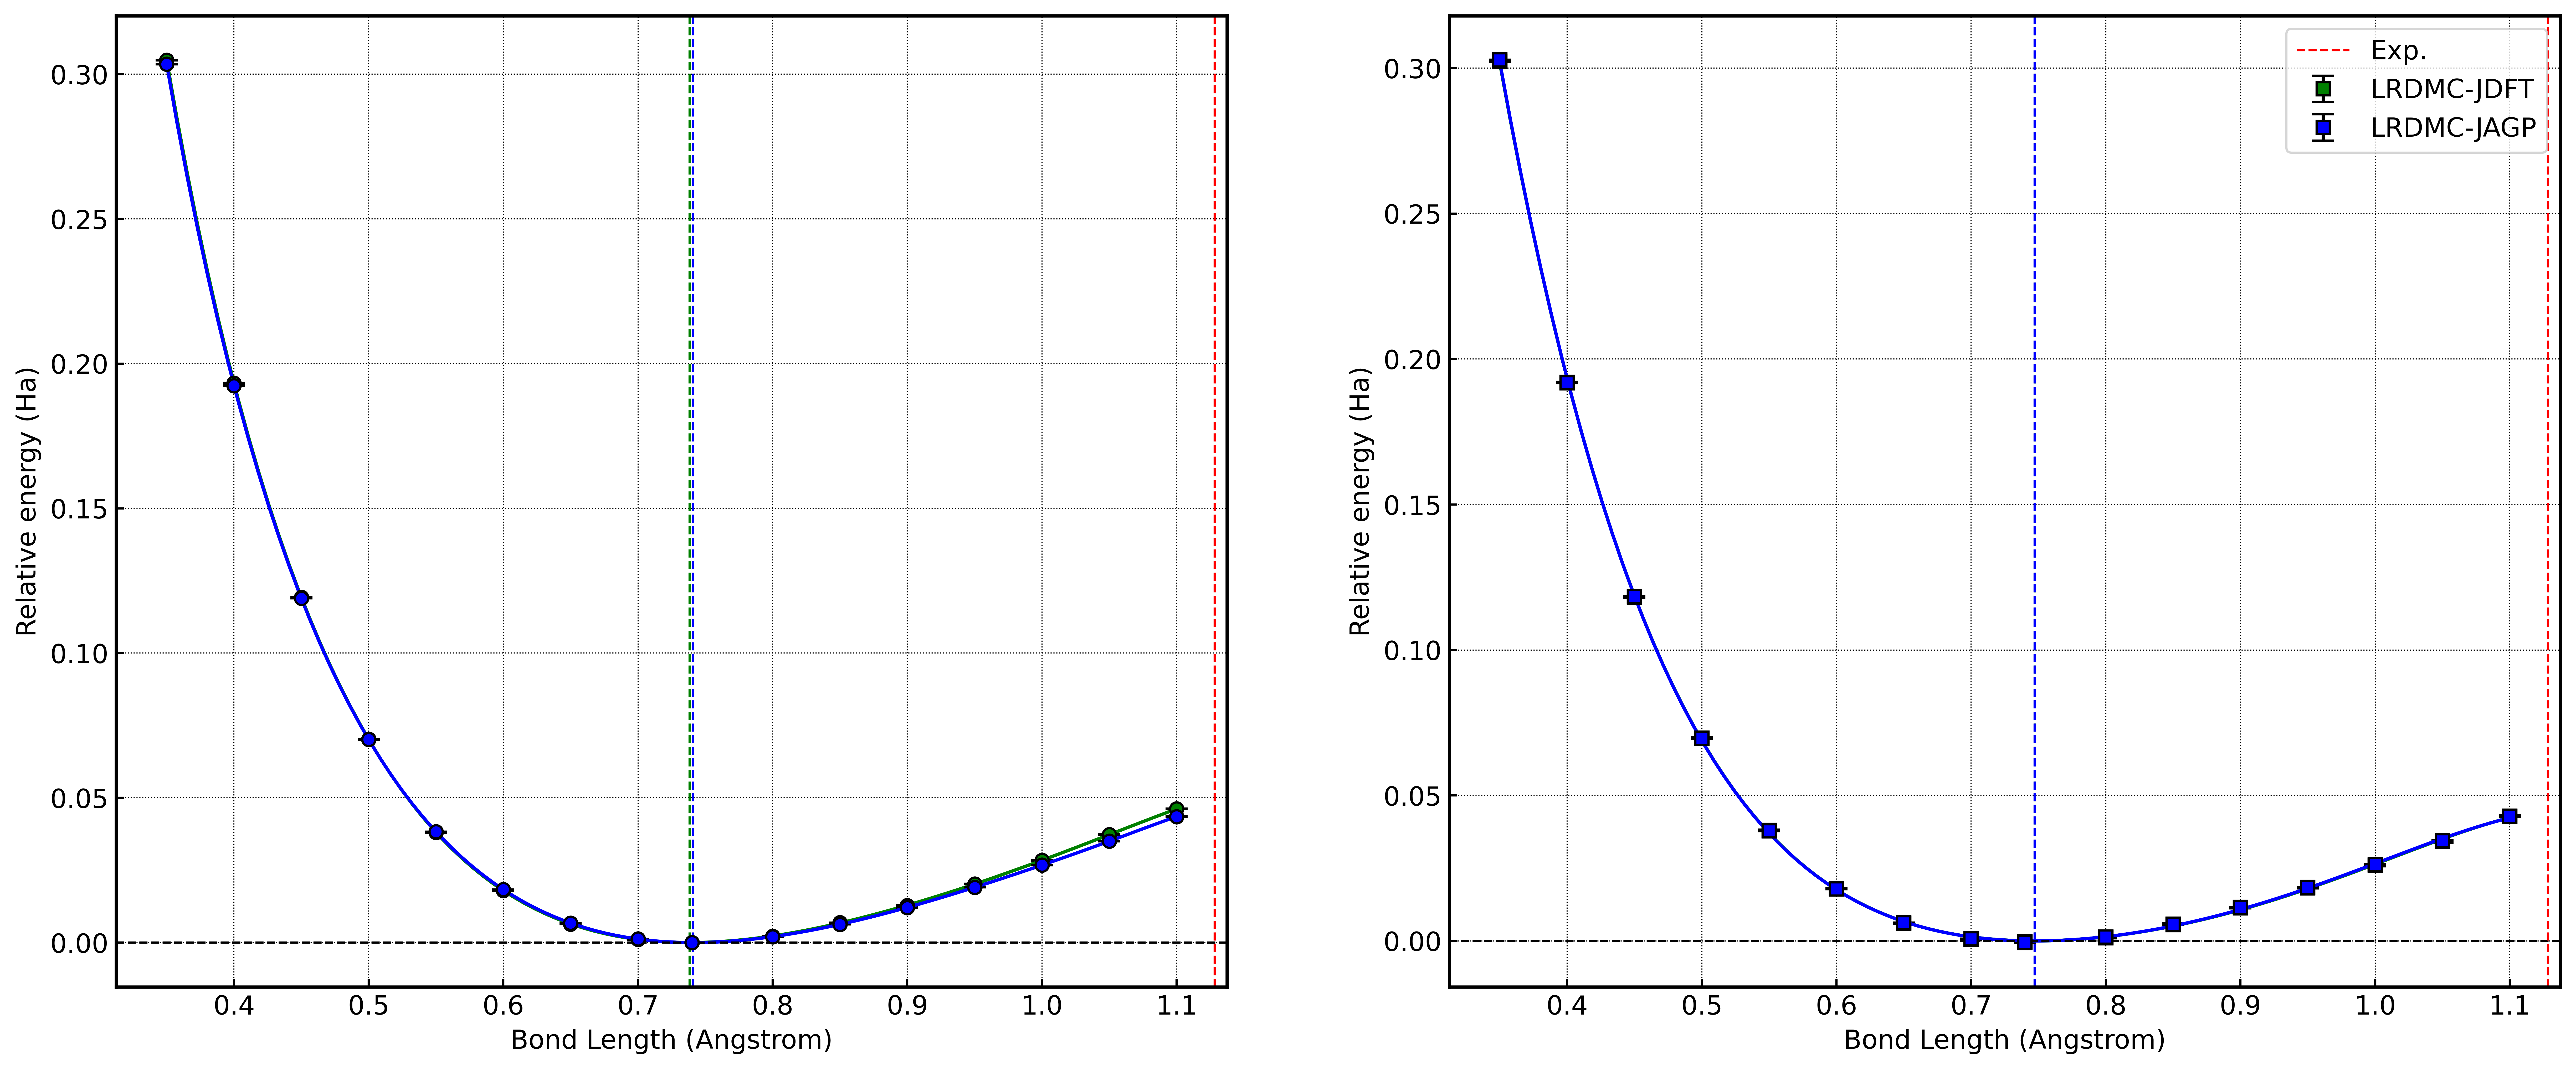

In [77]:
#plot Graph
interpolate_num=100
order=11

plt.rcParams['font.family'] ='sans-serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['font.size'] = 12 
plt.rcParams['axes.linewidth'] = 1.5 

fig = plt.figure(figsize=(20, 8), facecolor='white', dpi=600)

ax1 = fig.add_subplot(1,2,1)

#########################
# VMC
#########################

#VMC-SD
ene_vmc_sd_list=[e.n for e in e_jqmc_vmc_jsd_list]
err_vmc_sd_list=[e.s for e in e_jqmc_vmc_jsd_list]

x=R_list; y=ene_vmc_sd_list; y_err=err_vmc_sd_list
xs = np.linspace(np.min(x),np.max(x),interpolate_num)
x_zero_list, y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot, y_deriv_mean, y_deriv_std, y_deriv_mean_plot, y_deriv_std_plot, y_deriv_target_mean, y_deriv_target_std = fit_function_with_errors(x,y,y_err,xs,fit_type='PES',order=order)
energy_at_zero=y_zero_list.mean()

print("----------------------------------------------")
print(f"bond length(VMC-JDFT)={ufloat(np.mean(x_zero_list), np.std(x_zero_list)):.1uS} Angstrom")
plot_sigma=1
ax1.errorbar(x, y-energy_at_zero, yerr = y_err, capsize=5, fmt='o', markersize=6, ecolor='black', markeredgecolor = "black", color='g', label=f"VMC-JDFT")
ax1.plot(xs, y_mean_plot-energy_at_zero, color="g", linestyle="-")   
ax1.axvline(np.mean(x_zero_list), linestyle='--', color="g", linewidth=1.0)

#VMC-AGP
ene_vmc_agp_list=[e.n for e in e_jqmc_vmc_jagp_list]
err_vmc_agp_list=[e.s for e in e_jqmc_vmc_jagp_list]

x=R_list; y=ene_vmc_agp_list; y_err=err_vmc_agp_list
xs = np.linspace(np.min(x),np.max(x),interpolate_num)
x_zero_list, y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot, y_deriv_mean, y_deriv_std, y_deriv_mean_plot, y_deriv_std_plot, y_deriv_target_mean, y_deriv_target_std = fit_function_with_errors(x,y,y_err,xs,fit_type='PES',order=order)
energy_at_zero=y_zero_list.mean()

print(f"bond length(VMC-JAGP)={ufloat(np.mean(x_zero_list), np.std(x_zero_list)):.1uS} Angstrom")

plot_sigma=1
ax1.errorbar(x, y-energy_at_zero, yerr = y_err, capsize=5, fmt='o', markersize=6, ecolor='black', markeredgecolor = "black", color='b', label=f"VMC-JAGP")
ax1.plot(xs, y_mean_plot-energy_at_zero, color="b", linestyle="-")   
ax1.axvline(np.mean(x_zero_list), linestyle='--', color="b", linewidth=1.0)

#ax1.set_xlim(0,)
#ax1.set_ylim(5e-1,1e5)
ax1.axhline(0.0, linestyle='--', color="k", linewidth=1.0)
ax1.axvline(exp_bond_length, linestyle='--', color="r", linewidth=1.0, label="Exp.")

print(f"bond-length(CCSD(T))={ccsdt_bond_length} Angstrom")
print(f"bond-length(Exp.)={exp_bond_length} Angstrom")
print("----------------------------------------------")

ax1.set_xlabel(r'Bond Length (Angstrom)')
ax1.set_ylabel(r'Relative energy (Ha)')
ax1.grid(which="major", color='k', linestyle='dotted', linewidth=0.5)

#########################
# DMC
#########################
ax2 = fig.add_subplot(1,2,2)

#LRDMC-SD
ene_lrdmc_sd_list=[e.n for e in e_jqmc_lrdmc_jsd_list]
err_lrdmc_sd_list=[e.s for e in e_jqmc_lrdmc_jsd_list]

x=R_list; y=ene_lrdmc_sd_list; y_err=err_lrdmc_sd_list
xs = np.linspace(np.min(x),np.max(x),interpolate_num)
x_zero_list, y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot, y_deriv_mean, y_deriv_std, y_deriv_mean_plot, y_deriv_std_plot, y_deriv_target_mean, y_deriv_target_std = fit_function_with_errors(x,y,y_err,xs,fit_type='PES')
energy_at_zero=y_zero_list.mean()

print("----------------------------------------------")
print(f"bond-length(LRDMC-JDFT)={ufloat(np.mean(x_zero_list), np.std(x_zero_list)):.1uS} Angstrom")

plot_sigma=1
ax2.errorbar(x, y-energy_at_zero, yerr = y_err, capsize=5, fmt='s', markersize=6, ecolor='black', markeredgecolor = "black", color='g', label=f"LRDMC-JDFT")
ax2.plot(xs, y_mean_plot-energy_at_zero, color="g", linestyle="-")   
ax2.axvline(np.mean(x_zero_list), linestyle='--', color="g", linewidth=1.0)

#LRDMC-AGP
ene_lrdmc_agp_list=[e.n for e in e_jqmc_lrdmc_jagp_list]
err_lrdmc_agp_list=[e.s for e in e_jqmc_lrdmc_jagp_list]

x=R_list; y=ene_lrdmc_agp_list; y_err=err_lrdmc_agp_list
xs = np.linspace(np.min(x),np.max(x),interpolate_num)
x_zero_list, y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot, y_deriv_mean, y_deriv_std, y_deriv_mean_plot, y_deriv_std_plot, y_deriv_target_mean, y_deriv_target_std = fit_function_with_errors(x,y,y_err,xs,fit_type='PES')
energy_at_zero=y_zero_list.mean()

print(f"bond-length(LRDMC-JAGP)={ufloat(np.mean(x_zero_list), np.std(x_zero_list)):.1uS} Angstrom")

plot_sigma=1
ax2.errorbar(x, y-energy_at_zero, yerr = y_err, capsize=5, fmt='s', markersize=6, ecolor='black', markeredgecolor = "black", color='b', label=f"LRDMC-JAGP")
ax2.plot(xs, y_mean_plot-energy_at_zero, color="b", linestyle="-")   
ax2.axvline(np.mean(x_zero_list), linestyle='--', color="b", linewidth=1.0)

#ax1.set_xlim(0,)
#ax1.set_ylim(5e-1,1e5)
ax2.axhline(0.0, linestyle='--', color="k", linewidth=1.0)
ax2.axvline(exp_bond_length, linestyle='--', color="r", linewidth=1.0, label="Exp.")
print(f"bond-length(CCSD(T))={ccsdt_bond_length} Angstrom")
print(f"bond-length(Exp.)={exp_bond_length} Angstrom")
print("----------------------------------------------")

ax2.set_xlabel(r'Bond Length (Angstrom)')
ax2.set_ylabel(r'Relative energy (Ha)')
ax2.grid(which="major", color='k', linestyle='dotted', linewidth=0.5)

plt.legend()
plt.savefig('H2_PES_VMC_LRDMC.png')
plt.show()

----------------------------------------------
bond length(VMC-JDFT)=0.7383(9) Angstrom
bond-length(CCSD(T))=1.1325 Angstrom
bond-length(Exp.)=1.128323 Angstrom
----------------------------------------------
bond length(VMC-JAGP)=0.7408(3) Angstrom
bond-length(CCSD(T))=1.1325 Angstrom
bond-length(Exp.)=1.128323 Angstrom
----------------------------------------------


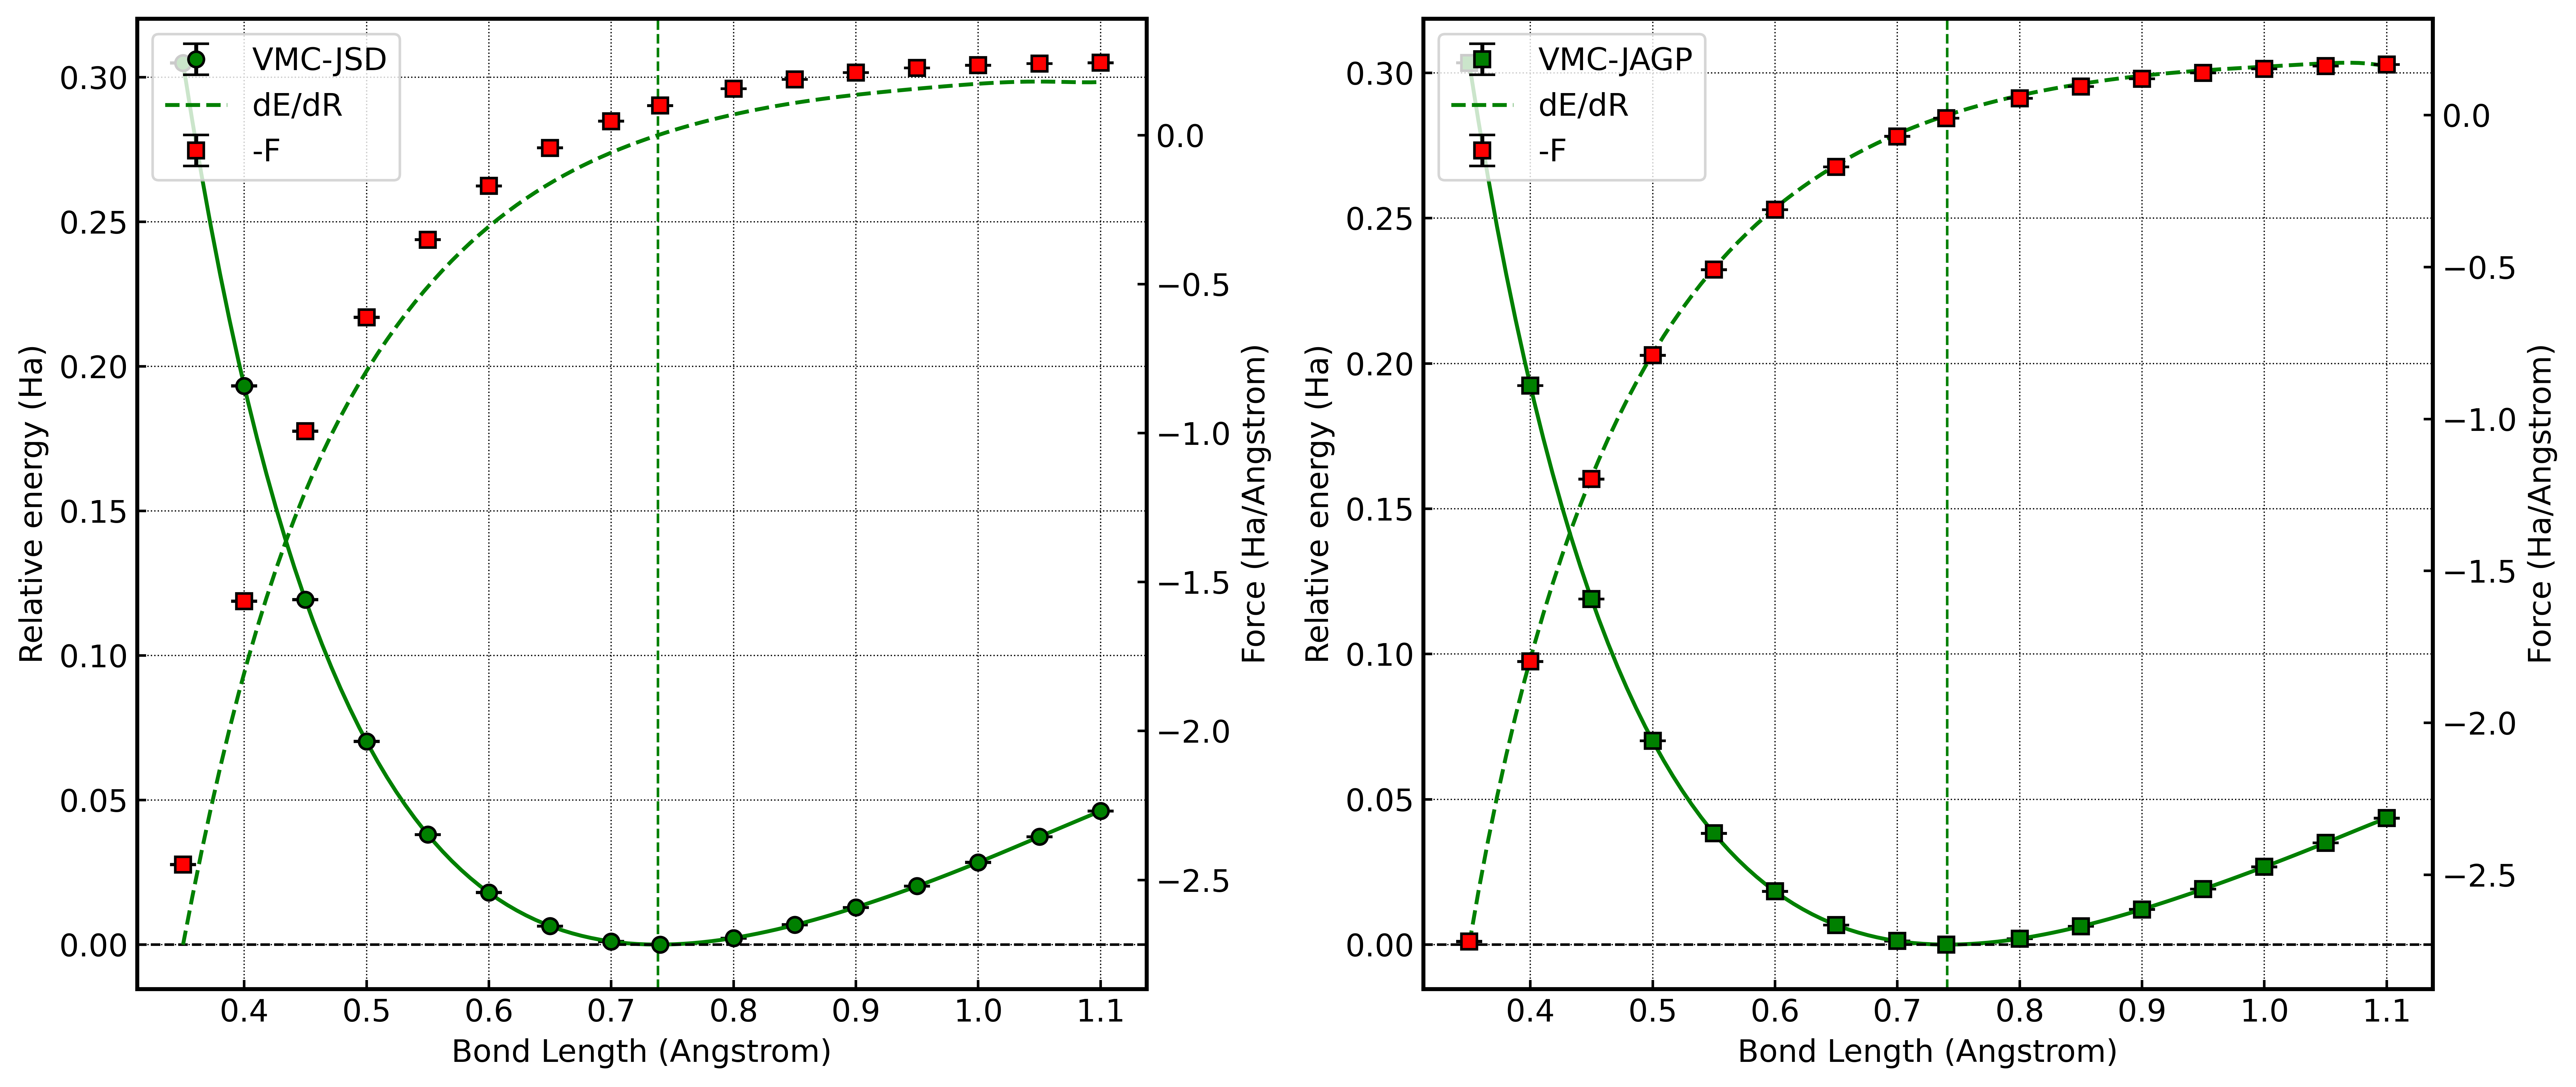

In [88]:
#plot Graph
interpolate_num=100
order=11

plt.rcParams['font.family'] ='sans-serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['font.size'] = 12 
plt.rcParams['axes.linewidth'] = 1.5 

fig = plt.figure(figsize=(14, 6), facecolor='white', dpi=600, tight_layout=True)

ax1 = fig.add_subplot(1,2,1)

#########################
# VMC
#########################

#VMC-SD
ene_vmc_sd_list=[e.n for e in e_jqmc_vmc_jsd_list]
err_vmc_sd_list=[e.s for e in e_jqmc_vmc_jsd_list]
f_vmc_sd_list=[f.n for f in f_jqmc_vmc_jsd_list]
ferr_vmc_sd_list=[f.s for f in f_jqmc_vmc_jsd_list]

x=R_list; y=ene_vmc_sd_list; y_err=err_vmc_sd_list
xs = np.linspace(np.min(x),np.max(x),interpolate_num)
x_zero_list, y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot, y_deriv_mean, y_deriv_std, y_deriv_mean_plot, y_deriv_std_plot, y_deriv_target_mean, y_deriv_target_std = fit_function_with_errors(x,y,y_err,xs,fit_type='PES',order=order)
energy_at_zero=y_zero_list.mean()

print("----------------------------------------------")
print(f"bond length(VMC-JDFT)={ufloat(np.mean(x_zero_list), np.std(x_zero_list)):.1uS} Angstrom")
plot_sigma=1
ax1.errorbar(x, y-energy_at_zero, yerr = y_err, capsize=5, fmt='o', markersize=6, ecolor='black', markeredgecolor = "black", color='g', label=f"VMC-JSD")
ax1.plot(xs, y_mean_plot-energy_at_zero, color="g", linestyle="-")   
ax1.axvline(np.mean(x_zero_list), linestyle='--', color="g", linewidth=1.0)

ax1_right = ax1.twinx()
ax1_right.plot(xs, y_deriv_mean_plot, color="g", linestyle="--", label="dE/dR")
x=R_list; y=f_vmc_sd_list; y_err=ferr_vmc_sd_list
ax1_right.errorbar(x, y, yerr = y_err, capsize=5, fmt='s', markersize=6, ecolor='black', markeredgecolor = "black", color='r', label="-F")

#ax1.set_xlim(0,)
#ax1.set_ylim(5e-1,1e5)
ax1.axhline(0.0, linestyle='--', color="k", linewidth=1.0)
#ax1.axvline(exp_bond_length, linestyle='--', color="r", linewidth=1.0, label="Exp.")

print(f"bond-length(CCSD(T))={ccsdt_bond_length} Angstrom")
print(f"bond-length(Exp.)={exp_bond_length} Angstrom")
print("----------------------------------------------")

ax1.set_xlabel(r'Bond Length (Angstrom)')
ax1.set_ylabel(r'Relative energy (Ha)')
ax1_right.set_ylabel(r'Force (Ha/Angstrom)')
ax1.grid(which="major", color='k', linestyle='dotted', linewidth=0.5)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_right.get_legend_handles_labels()
ax1_right.legend(lines + lines2, labels + labels2, loc='best')

#########################
# VMC (JAGP)
#########################
ax2 = fig.add_subplot(1,2,2)

#VMC-AGP
ene_vmc_agp_list=[e.n for e in e_jqmc_vmc_jagp_list]
err_vmc_agp_list=[e.s for e in e_jqmc_vmc_jagp_list]
f_vmc_agp_list=[f.n for f in f_jqmc_vmc_jagp_list]
ferr_vmc_agp_list=[f.s for f in f_jqmc_vmc_jagp_list]

x=R_list; y=ene_vmc_agp_list; y_err=err_vmc_agp_list
xs = np.linspace(np.min(x),np.max(x),interpolate_num)
x_zero_list, y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot, y_deriv_mean, y_deriv_std, y_deriv_mean_plot, y_deriv_std_plot, y_deriv_target_mean, y_deriv_target_std = fit_function_with_errors(x,y,y_err,xs,fit_type='PES',order=order)
energy_at_zero=y_zero_list.mean()

print(f"bond length(VMC-JAGP)={ufloat(np.mean(x_zero_list), np.std(x_zero_list)):.1uS} Angstrom")

plot_sigma=1
ax2.errorbar(x, y-energy_at_zero, yerr = y_err, capsize=5, fmt='s', markersize=6, ecolor='black', markeredgecolor = "black", color='g', label=f"VMC-JAGP")
ax2.plot(xs, y_mean_plot-energy_at_zero, color="g", linestyle="-")   
ax2.axvline(np.mean(x_zero_list), linestyle='--', color="g", linewidth=1.0)

ax2_right = ax2.twinx()
ax2_right.plot(xs, y_deriv_mean_plot, color="g", linestyle="--", label="dE/dR")
x=R_list; y=f_vmc_agp_list; y_err=ferr_vmc_agp_list
ax2_right.errorbar(x, y, yerr = y_err, capsize=5, fmt='s', markersize=6, ecolor='black', markeredgecolor = "black", color='r', label="-F")

#ax1.set_xlim(0,)
#ax1.set_ylim(5e-1,1e5)
ax2.axhline(0.0, linestyle='--', color="k", linewidth=1.0)
#ax2.axvline(exp_bond_length, linestyle='--', color="r", linewidth=1.0, label="Exp.")
print(f"bond-length(CCSD(T))={ccsdt_bond_length} Angstrom")
print(f"bond-length(Exp.)={exp_bond_length} Angstrom")
print("----------------------------------------------")

ax2.set_xlabel(r'Bond Length (Angstrom)')
ax2.set_ylabel(r'Relative energy (Ha)')
ax2_right.set_ylabel(r'Force (Ha/Angstrom)')
ax2.grid(which="major", color='k', linestyle='dotted', linewidth=0.5)

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_right.get_legend_handles_labels()
ax2_right.legend(lines + lines2, labels + labels2, loc='best')

plt.savefig('H2_PES_VMC.jpg')
plt.show()